# Remove old data from folders and create data folders to save plots and cleaned data to

In [36]:
import os
import shutil
from typing import List

clean_folder_names = ['data/uncleaned_plots', 'data/cleaned_data', 'data/cleaned_plots']
def remove_old_data_from_folders(clean_folder_names):
    for folder in clean_folder_names:
        if os.path.exists(folder) and os.path.isdir(folder):
            shutil.rmtree(folder)

create_folder_names = ['data', 'data/uncleaned_plots', 'data/cleaned_data', 'data/cleaned_plots']
def create_data_folders(create_folder_names):
    for folder in create_folder_names:
        if not os.path.exists(folder):
            os.makedirs(folder)  # creates all intermediate directories if needed

remove_old_data_from_folders(clean_folder_names)
create_data_folders(create_folder_names)

# Source/Destination Path Locations

In [37]:
# do you want to save the plots and cleaned data generated in this file to the path destinations below?
# Keep on false when testing, as it runs much faster when not saving figuresS
save_bool = True

# the source folder of the uncleaned csv data
uncleaned_data_src = "misc_data/mason_iris_data"

# location for saving cleaned csv files
save_cleaned_csv_dst = "data/cleaned_data"

# location for saving uncleaned plots, in folder it'll look like: resistance_depth_1, resistance_depth_2, ...
save_uncleaned_plots_dst = "data/uncleaned_plots"

# location for saving cleaned plots
save_cleaned_plots_dst = "data/cleaned_plots"

# user-defined index of example depth-resistance curve to plot after each data transformation
plot_idx = 0

# Read in white sands csv files and turn them into dataframes

In [38]:
import os
import pandas as pd

def cm_to_m(cm):
    return cm / 100

def find_ground(df: pd.DataFrame):
    return cm_to_m(df['ground_height'].iloc[0])

def load_data(data_src_folder_path, remove_list):

    df_list = []
    filenames_list = []
    ground_start_list = []
    for filename in os.listdir(data_src_folder_path):

        if filename in remove_list: continue

        df = pd.read_csv(f"{data_src_folder_path}/{filename}", skiprows=2)
        df = df[['toeforce_y', 'toe_position_y']] # takes just the two important columns
        df.columns = ["resistance", "depth"] # rename columns

        df_list.append(df)
        filenames_list.append(filename)
        ground = find_ground(pd.read_csv(f"{data_src_folder_path}/{filename}"))
        ground_start_list.append(ground)

    return df_list, filenames_list, ground_start_list

# list of plots you wish to remove from data (bad samples, ect)
remove_filename_list = [] # initially empty unless user adds filenames
df_list, filenames_list, ground_start_list = load_data(uncleaned_data_src, remove_filename_list)

# Data Visualization

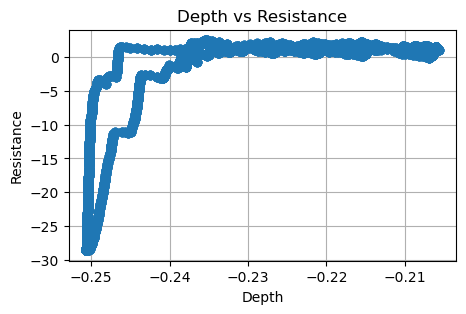

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot(df_list, idx=plot_idx, title='Depth vs Resistance'):
    plt.figure(figsize=(5,3))
    plt.plot(df_list[idx]['depth'], df_list[idx]['resistance'], marker='o', linestyle='-')
    plt.xlabel('Depth')
    plt.ylabel('Resistance')
    plt.title(title)
    plt.grid(True)                    
    plt.show()
    
"""This function will be used at the very end of the cleaning process for comparing before and after cleaning of plots"""
def compare_plots_before_after_cleaning(uncleaned_df_list, cleaned_df_list, removed_list=[], plot_indicies=[]):
    uncleaned_idx = 0
    cleaned_idx = 0
    for i in range(len(uncleaned_df_list)):
        if i not in removed_list:
            if i in plot_indicies:
                print(f"uncleaned idx: {uncleaned_idx}")
                plot(uncleaned_df_list, uncleaned_idx, 'Uncleaned: Depth vs Resistance')
                print(f"cleaned idx: {cleaned_idx}")
                plot(cleaned_df_list, cleaned_idx, 'Cleaned: Depth vs Resistance')
                print("-----------------------------------------------------------")
            uncleaned_idx += 1
            cleaned_idx += 1
        else:
            uncleaned_idx += 1
    
def save_plots(df_list, filenames_list, save_plots_dst, save_bool=False, same_axis_range=True):
    if save_bool:
        combined_columnes = pd.concat(df_list, axis=0)
        for i, df in enumerate(df_list):
            plt.figure(figsize=(8,6))         # Optional: set figure size
            plt.plot(df['depth'], df['resistance'], marker='o', linestyle='-')
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            if "uncleaned" not in save_plots_dst and same_axis_range:
                plt.xlim([0, combined_columnes['depth'].max()])
                plt.ylim([0, combined_columnes['resistance'].max()])
            plt.title('Depth vs Resistance')
            plt.grid(True)
            plt.savefig(f"{save_plots_dst}/{filenames_list[i][:-3]}") # sliceing by -3 gets rid of extra '.csv' in filename
            plt.close()
    
def generate_box_plots(df_list):
    df_combined_row_wise = pd.concat(df_list, axis=0)
    plt.figure(figsize=(3,2))         # Optional: set figure size
    # ---- resistance ----
    sns.boxplot(x=df_combined_row_wise['resistance'])
    plt.show()
    resistance_series = df_combined_row_wise['resistance']
    # ---- depth ----
    plt.figure(figsize=(3,2))         # Optional: set figure size
    sns.boxplot(x=df_combined_row_wise['depth'])
    plt.show()

def generate_histograms(df_list):
    df_combined_row_wise = pd.concat(df_list, axis=0)
    plt.hist(df_combined_row_wise["resistance"], bins=30, density=True)
    plt.title("Resistance Histogram")
    plt.show()

    plt.hist(df_combined_row_wise["depth"], bins=30, density=True)
    plt.title("Depth Histogram")
    plt.show()

save_plots(df_list, filenames_list, save_uncleaned_plots_dst, save_bool, same_axis_range=False)
plot(df_list)

# Flip curve over y-axis

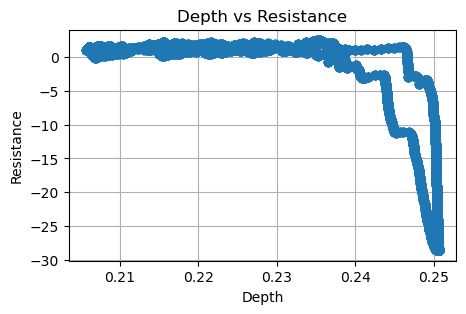

In [ ]:
def flip_over_y_axis(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df['depth'] = -copy_df['depth']
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = flip_over_y_axis(df_list)
plot(df_list)

# Flip over x-axis

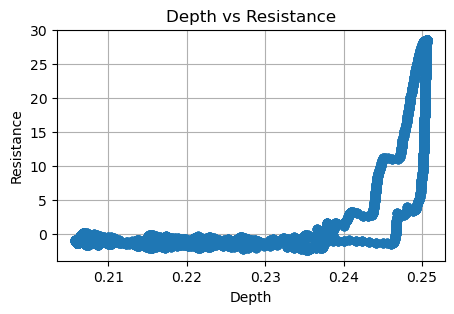

In [41]:
def flip_over_x_axis(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df['resistance'] = -copy_df['resistance']
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = flip_over_x_axis(df_list)
plot(df_list)

# Remove all data points after the max depth

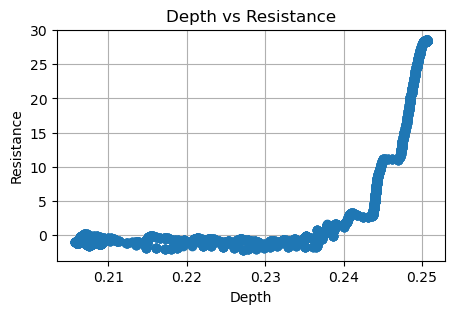

In [42]:
def remove_points_after_max_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        end_idx = df[df["depth"] == df["depth"].max()].index[0]
        cleaned_df = df.iloc[:end_idx+1]
        cleaned_list.append(cleaned_df)
    return cleaned_list

df_list = remove_points_after_max_depth(df_list)
plot(df_list)

# Remove all data points before min depth

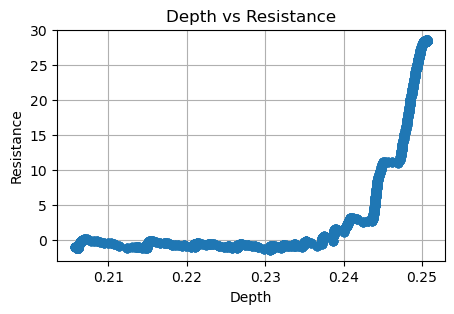

In [43]:
def remove_points_before_min_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        min_idx = df[df["depth"] == df["depth"].min()].index[0]
        cleaned_df = df.iloc[min_idx:]
        cleaned_list.append(cleaned_df)
    return cleaned_list

# plot(df_list)
df_list = remove_points_before_min_depth(df_list)
plot(df_list)

# Make resistance = 0 for all resistance values < 0

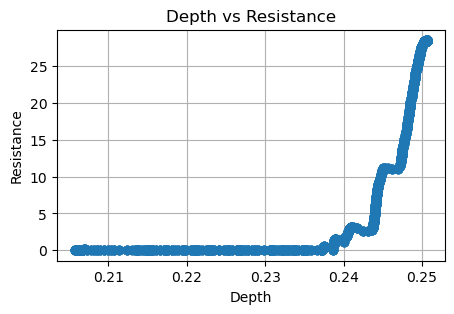

In [44]:
def make_resistance_min_equal_zero(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df["resistance"] = copy_df["resistance"].clip(lower=0)
        cleaned_df_list.append(copy_df)
    return cleaned_df_list
df_list = make_resistance_min_equal_zero(df_list)
plot(df_list)

# Make sure depth values are only increasing

Number of dataframes with non-ascending values: 20


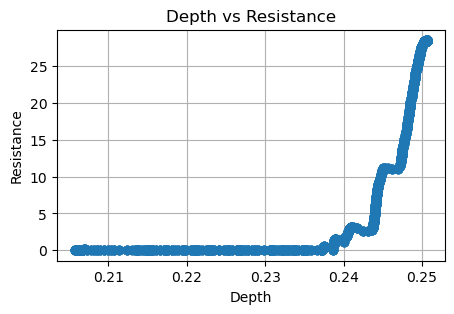

Number of dataframes with non-ascending values: 0


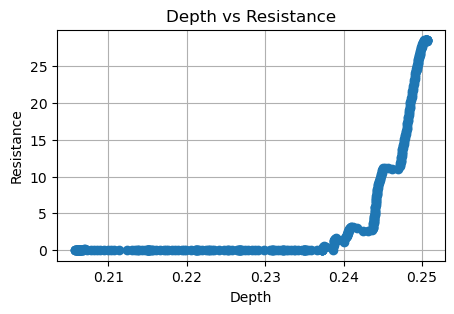

In [45]:
def num_dataframes_with_ascending_depth(df_list):
    count = 0
    for df in df_list:
        if not (df['depth'].is_monotonic_increasing and df['depth'].is_unique): 
            count += 1
    return count

def only_increasing_depth(df_list):
    cleaned_df_list = []
    for df in df_list:
        mask = [1]  # keep the first row
        current_max_depth = df['depth'].iloc[0]
        for i in range(1, len(df)):
            if df['depth'].iloc[i] > current_max_depth:
                current_max_depth = df['depth'].iloc[i]
                mask.append(1)
            else:
                mask.append(0)
        mask_series = pd.Series(mask, index=df.index)
        cleaned_df_list.append(df.loc[mask_series.astype(bool)])

    return cleaned_df_list

# show before and after
print(f"Number of dataframes with non-ascending values: {num_dataframes_with_ascending_depth(df_list)}")
plot(df_list)
df_list = only_increasing_depth(df_list)
print(f"Number of dataframes with non-ascending values: {num_dataframes_with_ascending_depth(df_list)}")
plot(df_list)

# Start each depth-resistance curve when arm first contacts the ground

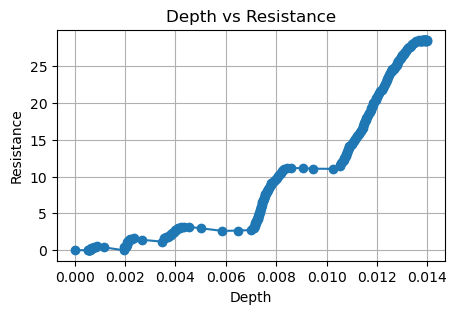

In [46]:
def start_curve_at_ground(df_list: List[pd.DataFrame]):
    updated_df_list = []
    for i, df in enumerate(df_list):
        df = df.copy()
        df = df[df['depth'] > ground_start_list[i]].reset_index()
        df['depth'] = df['depth'] - df['depth'].iloc[0]
        updated_df_list.append(df)
    return updated_df_list

df_list = start_curve_at_ground(df_list)
plot(df_list)


# Interpolation to uniformly resample points from curve

Before interpolation


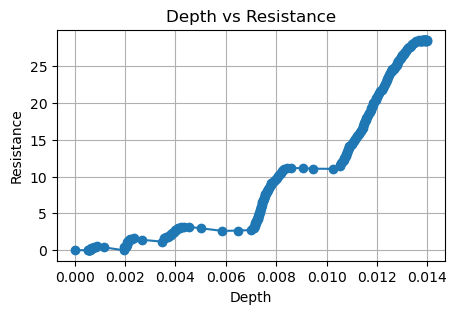

After interpolation


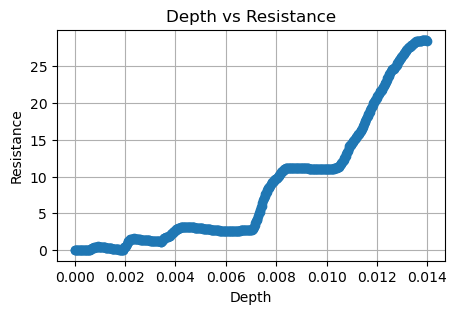

In [47]:
import numpy as np
def interpolate(df_list, num_points):
    interp_df_list = []
    for df in df_list:
        x_intervals = np.linspace(0, df['depth'].max(), num_points, endpoint=True) # 100 points between 0 and trunc_level
        y_new = np.interp(x_intervals, df["depth"], df["resistance"])
        new_df = pd.DataFrame({'depth': x_intervals, 'resistance': y_new})
        interp_df_list.append(new_df)
    return interp_df_list

print("Before interpolation")
plot(df_list)
df_list = interpolate(df_list, 500)
print("After interpolation")
plot(df_list)

# Max slope variable

In [48]:
def find_max_slope(df_list):
    max_slope_list = []
    for i, df in enumerate(df_list):
        print(f'filename: {filenames_list[i]}')
        res = df['resistance']
        dep = df['depth']
        min_idx = res.idxmin()
        max_idx = res.idxmax()
        max_slope = (res.iloc[max_idx] - res.iloc[min_idx]) / (dep.iloc[max_idx] - dep.iloc[min_idx])
        max_slope_list.append(float(max_slope))
    return max_slope_list

print(find_max_slope(df_list))


filename: WS25_Aug5_Loc1A_T1_F10_0958.csv
filename: WS25_Aug5_Loc1A_T1_F15_1026.csv
filename: WS25_Aug5_Loc1A_T1_F6_0930.csv
filename: WS25_Aug5_Loc1A_T1_F8_0955.csv
filename: WS25_Aug5_Loc1A_T1_F2_0919.csv
filename: WS25_Aug5_Loc1A_T1_F11_1008.csv
filename: WS25_Aug5_Loc1A_T1_F24_1057.csv
filename: WS25_Aug5_Loc1A_T1_F7_0952.csv
filename: WS25_Aug5_Loc1A_T1_F3_0926.csv
filename: WS25_Aug5_Loc1A_T1_F5_0929.csv
filename: WS25_Aug5_Loc1A_T1_F9_0957.csv
filename: WS25_Aug5_Loc1A_T1_F25_1058.csv
filename: WS25_Aug5_Loc1A_T1_F1_0918.csv
filename: WS25_Aug5_Loc1A_T1_F13_1012.csv
filename: WS25_Aug5_Loc1A_T1_F14_1024_A2.csv
filename: WS25_Aug5_Loc1A_T1_F12_1010.csv
filename: WS25_Aug5_Loc1A_T1_F28_1101.csv
filename: WS25_Aug5_Loc1A_T1_F16_1028.csv
filename: WS25_Aug5_Loc1A_T1_F4_0927.csv
filename: WS25_Aug5_Loc1A_T1_F17_1029.csv
[2045.8971852707311, 8695.377613793811, 1436.5609293534512, 1744.1000066107624, 908.6329982171404, 4108.032072721613, 1823.4127169295703, 2919.2457478761517, 1524.798

# Save photos of all cleaned curves

In [49]:
save_plots(df_list, filenames_list, save_cleaned_plots_dst, save_bool, same_axis_range=False)

# Save the cleaned csv files and filenames

In [50]:
def save_data_csv(final_df_list, filenames_list, save_dst, save_bool: bool):
    if save_bool:
        for i in range(len(final_df_list)):
            final_df_list[i].to_csv(f"{save_dst}/{filenames_list[i]}")

save_data_csv(df_list, filenames_list, save_dst=save_cleaned_csv_dst, save_bool=save_bool)
